In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

### Create model and train

In [7]:
embedder = tfUMAP(verbose=True)

In [8]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f79f827f240>,
       tensorboard_logdir='/tmp/tensorboard/20200707-100109')
Construct fuzzy simplicial set
Tue Jul  7 10:01:10 2020 Finding Nearest Neighbors
Tue Jul  7 10:01:10 2020 Building RP forest with 17 trees
Tue Jul  7 10:01:12 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Tue Jul  7 10:01:23 2020 Finished Nearest Neighbor Search
Tue Jul  7 10:01:29 2020 Embedding with TensorFlow


Tue Jul  7 10:07:57 2020 Finished embedding


### Plot model output

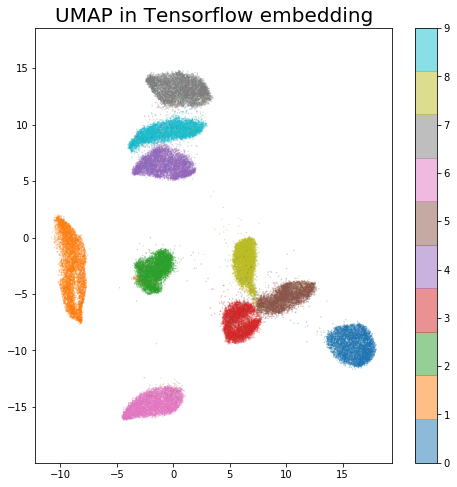

In [9]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [10]:
z_test = embedder.transform(X_test_flat)

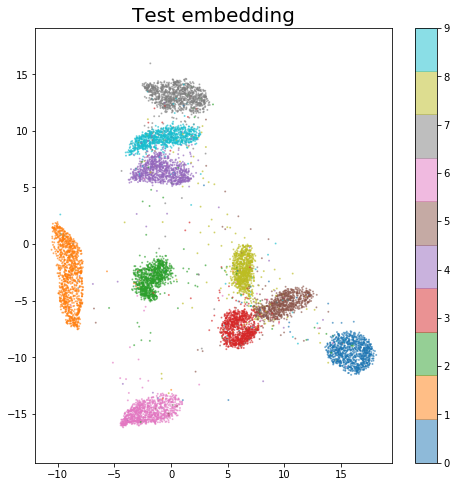

In [11]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=1.0,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [12]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [13]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594141e+09,1,2.468201,train,umap_loss
1,1.594141e+09,2,2.142378,train,umap_loss
2,1.594141e+09,3,1.874683,train,umap_loss


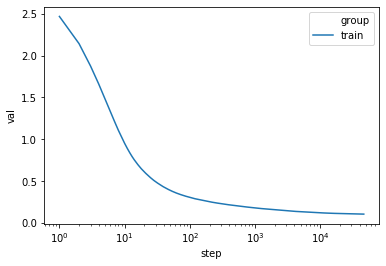

In [14]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Compare to direct embedding with base UMAP

In [15]:
from umap import UMAP

In [16]:
z_umap = UMAP(verbose=True).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Jul  7 10:08:08 2020 Finding Nearest Neighbors
Tue Jul  7 10:08:08 2020 Building RP forest with 17 trees
Tue Jul  7 10:08:09 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Tue Jul  7 10:08:11 2020 Finished Nearest Neighbor Search
Tue Jul  7 10:08:11 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jul  7 10:08:45 2020 Finished embedding


In [17]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.3234032072699809


Text(0.5, 1.0, 'UMAP with UMAP-learn')

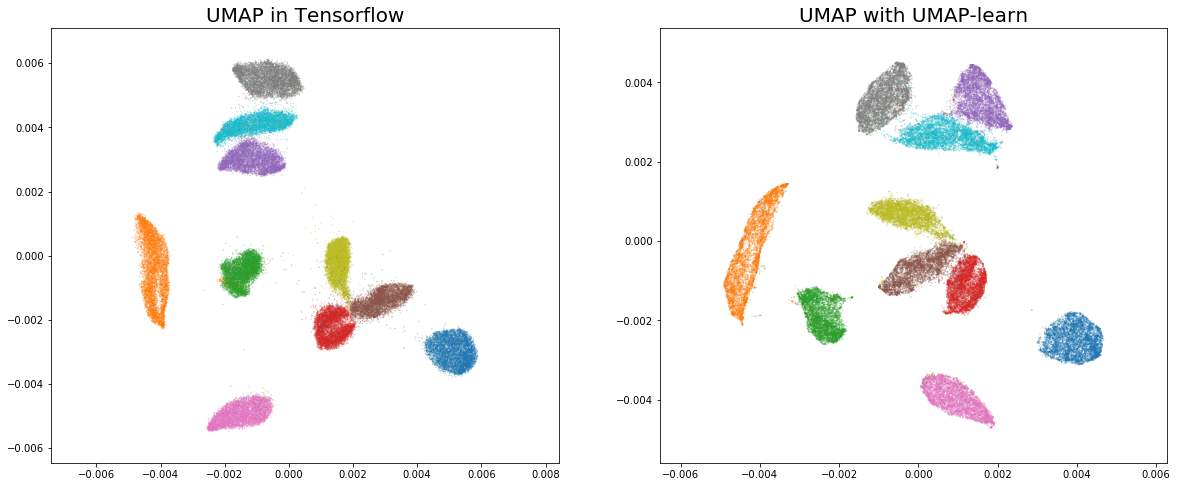

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);